In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
# Modeling imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost  import XGBRegressor
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import StratifiedKFold
import optuna
from optuna.samplers import TPESampler
from colorama import Fore, Style
import seaborn as sns

CLR = (Style.BRIGHT + Fore.BLACK) 
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
RESET = Style.RESET_ALL

In [2]:
#Reading Files
path = "/Users/larst/OneDrive/Documents/GitHub/KaggleS3E20/data/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")
sample_sub = pd.read_csv(path+"sample_submission.csv")

In [3]:
def get_coordinates(lat, lon):
    return "(" + lat.astype(str) + ", " + lon.astype(str) + ")"


train["Coordinates"] = get_coordinates(train.latitude, train.longitude)
test["Coordinates"] = get_coordinates(test.latitude, test.longitude)



In [4]:
def extract_date_from_year_and_week(year, week):
    return pd.to_datetime(year, format="%Y") + pd.to_timedelta(week.mul(7), unit="days")


train["Date"] = extract_date_from_year_and_week(train.year, train.week_no)
test["Date"] = extract_date_from_year_and_week(test.year, test.week_no)

train["month_no"] = train.Date.dt.month
test["month_no"] = test.Date.dt.month



In [5]:
train_geo_pairs = train["Coordinates"].drop_duplicates().to_numpy()
test_geo_pairs = test["Coordinates"].drop_duplicates().to_numpy()

train_years = train.year.unique()
test_years = test.year.unique()

train_weeks = train.week_no.unique()
test_weeks = test.week_no.unique()

print(CLR + "Unique Geographical Locations in Train: ", RED + str(len(train_geo_pairs)))
print(CLR + "Unique Geographical Locations in Test:  ", RED + str(len(train_geo_pairs)), "\n")

print(CLR + "Years in Train:                        ", RED, *train_years)
print(CLR + "Years in Test:                         ", RED, *test_years, "\n")

print(CLR + "Weeks in Train:                        ", RED, train_weeks[0], "...", train_weeks[-1])
print(CLR + "Weeks in Test:                         ", RED, test_weeks[0], "...", test_weeks[-1])

Unique Geographical Locations in Train:  497
Unique Geographical Locations in Test:   497 

Years in Train:                          2019 2020 2021
Years in Test:                           2022 

Weeks in Train:                          0 ... 52
Weeks in Test:                           0 ... 48


In [6]:
assert np.all(train_geo_pairs == test_geo_pairs)  # Are there the same locations?
assert len(train_geo_pairs) * len(train_years) * len(train_weeks) == len(train)
assert len(test_geo_pairs) * len(test_years) * len(test_weeks) == len(test)

In [7]:
FONT_COLOR = "#2D425E"
BACKGROUND_COLOR = "#FFFCFA"

CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": "background-color: #F2F2F0",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": "color: #2D425E; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": "font-style: italic; font-weight: normal; background-color: #FFFCFA; color: #3E3F4C;",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": "font-style: italic; font-weight: normal; background-color: #FFFCFA; color: #3E3F4C;",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)
DF_CMAP = sns.light_palette("#E04C5F", as_cmap=True)

In [8]:
missing_values = pd.DataFrame(index=test.columns)
missing_values["MissingTrain"] = train.isna().sum()
missing_values["MissingTrainNormalised"] = missing_values.MissingTrain / len(train)
missing_values["MissingTest"] = test.isna().sum()
missing_values["MissingTestNormalised"] = missing_values.MissingTest / len(test)
missing_values.style.set_table_styles(DF_STYLE).background_gradient(DF_CMAP)



,MissingTrain,MissingTrainNormalised,MissingTest,MissingTestNormalised
ID_LAT_LON_YEAR_WEEK,0,0.000000,0,0.000000
latitude,0,0.000000,0,0.000000
longitude,0,0.000000,0,0.000000
year,0,0.000000,0,0.000000
week_no,0,0.000000,0,0.000000
SulphurDioxide_SO2_column_number_density,14609,0.184870,6142,0.252207
SulphurDioxide_SO2_column_number_density_amf,14609,0.184870,6142,0.252207
SulphurDioxide_SO2_slant_column_number_density,14609,0.184870,6142,0.252207
SulphurDioxide_cloud_fraction,14609,0.184870,6142,0.252207
SulphurDioxide_sensor_azimuth_angle,14609,0.184870,6142,0.252207


In [9]:
cols_to_reject = train.columns[train.columns.str.startswith("Uvaerosollayerheight")]

train = train.drop(cols_to_reject, axis=1)
test = test.drop(cols_to_reject, axis=1)



In [10]:
mean_emission_by_loc = train.groupby("Coordinates").emission.mean()
zero_emission_loc = mean_emission_by_loc[mean_emission_by_loc == 0]
print(
    CLR + "Always Zero-Emission Locations:\n\n",
    zero_emission_loc,
    CLR + "\n\nNumber of Locations with Always Zero-Emission: ",
    RED + f"{len(zero_emission_loc)}",
    sep="",
)

Always Zero-Emission Locations:

Coordinates
(-1.328, 28.872)    0.0
(-1.505, 30.995)    0.0
(-1.532, 28.568)    0.0
(-1.682, 29.218)    0.0
(-1.696, 28.304)    0.0
(-1.712, 28.688)    0.0
(-1.73, 28.47)      0.0
(-1.833, 28.467)    0.0
(-1.839, 28.761)    0.0
(-1.974, 28.526)    0.0
(-2.496, 28.504)    0.0
(-2.817, 29.283)    0.0
(-2.841, 29.159)    0.0
(-2.859, 29.041)    0.0
(-2.898, 29.002)    0.0
Name: emission, dtype: float64

Number of Locations with Always Zero-Emission: 15


In [11]:
# Calculate the average monthly sales for non-virus years (2019 and 2021)
avg_emission_non_virus = train[train['year'].isin((2019,2021))].groupby('week_no')['emission'].mean()

# Calculate the average monthly for virus year (2020)
avg_emission_virus = train[train['year'] == 2020].groupby('week_no')['emission'].mean()

# Calculate the ratios for each month
ratios_for_weeks = avg_emission_non_virus/avg_emission_virus

# Multiply the num_sold column for each row in 2020 by the corresponding ratio for the week of that row
train.loc[train['year'] == 2020, 'emission'] *= train['week_no'].map(ratios_for_weeks)

In [12]:
# Let's fix the large spike in the last week of 2020. It's an outlier.
train.loc[(train['week_no'] == 52) & (train['year'] == 2020), 'emission'] = np.power(train.loc[(train['week_no'] == 52) & (train['year'] == 2020), 'emission'], 1/1.5)



In [13]:
train['season'] = train['Date'].dt.month.apply(lambda x: 1 if 3 <= x <= 5 else 2 if 6 <= x <= 8 else 3 if 9 <= x <= 11 else 4)

In [14]:
train['holidays'] = (train['week_no'].isin([0, 51, 12, 30]))

In [15]:
train['week_sin'] = np.sin(2 * np.pi * train['week_no']/53)
train['week_cos'] = np.cos(2 * np.pi * train['week_no']/53)


In [16]:
# From Yang Zhou https://www.kaggle.com/code/yaaangzhou/en-playground-s3-e20-eda-modeling
train['rot_15_x'] = (np.cos(np.radians(15)) * train['longitude']) + (np.sin(np.radians(15)) * train['latitude'])

train['rot_15_y'] = (np.cos(np.radians(15)) * train['latitude']) + (np.sin(np.radians(15)) * train['longitude'])

train['rot_30_x'] = (np.cos(np.radians(30)) * train['longitude']) + (np.sin(np.radians(30)) * train['latitude'])

train['rot_30_y'] = (np.cos(np.radians(30)) * train['latitude']) + (np.sin(np.radians(30)) * train['longitude'])

In [17]:


training_cols = ['latitude', 'longitude', 'year', 'week_sin', 'week_cos', 'holidays', 'rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y']



In [18]:


X_train = train.drop(columns='emission')
y = train['emission']



In [19]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    QuantileTransformer(output_distribution='normal', random_state=26), # normalizes columns
    StandardScaler()
)



In [20]:
X_transformed = pipeline.fit_transform(X_train[training_cols])

In [21]:
X_transformed = pd.DataFrame(X_transformed, columns=pipeline.get_feature_names_out(), index=X_train.index) # train.columns would give the same result as pipeline.get_feature_names_out() beacuse we didn't use any transformer that adds/deletes/changes columns eg. OneHotEncoder
X_transformed.head()



,latitude,longitude,year,week_sin,week_cos,holidays,rot_15_x,rot_15_y,rot_30_x,rot_30_y
0,5.058101,-0.617651,-1.224745,-0.001955,3.517715,3.500000,-0.26156,1.651419,0.173212,1.014907
1,5.058101,-0.617651,-1.224745,0.064671,1.165168,-0.285714,-0.26156,1.651419,0.173212,1.014907
2,5.058101,-0.617651,-1.224745,0.135569,1.003248,-0.285714,-0.26156,1.651419,0.173212,1.014907
3,5.058101,-0.617651,-1.224745,0.212516,0.885661,-0.285714,-0.26156,1.651419,0.173212,1.014907
4,5.058101,-0.617651,-1.224745,0.285676,0.769476,-0.285714,-0.26156,1.651419,0.173212,1.014907


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)]


# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4,6, 8]

# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestRegressor()
random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, verbose=200, n_jobs = -1)
random.fit(X_transformed, y)


In [22]:
param_rf = {'n_estimators': 181, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_depth': 23, 'bootstrap': True}

# print best parameter after tuning
print(random.best_params_)
# print how our model looks after hyper-parameter tuning
print(random.best_estimator_)
grid_predictions = random.predict(X_transformed)

model = RandomForestRegressor(min_samples_leaf=6, random_state=26)

model.fit(X_transformed, y)

In [23]:
model_rf = RandomForestRegressor(**param_rf)
model_rf.fit(X_transformed, y)

RandomForestRegressor(max_depth=23, min_samples_leaf=8, min_samples_split=5,
                      n_estimators=181)

gkf = GroupKFold(3)

scores = -cross_val_score(model_rf, X_transformed, y, scoring="neg_root_mean_squared_error", cv=gkf.split(X_transformed, y, groups=train['year']))

print(f'Training RMSE: {mean_squared_error(y, model_rf.predict(X_transformed), squared=False):.2f}')
print(f"Cross validation RMSE: {scores.mean():.2f}")

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model_xgb = XGBRegressor(**param)
    model_xgb.fit(X_transformed, y)
    scores = -cross_val_score(model_xgb, X_transformed, y, scoring="neg_root_mean_squared_error", cv=gkf.split(X_transformed, y, groups=train['year']))
    rep = scores.mean()
    return rep

# Create the study
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=100)


In [24]:
params_xgb= {'max_depth': 25, 'learning_rate': 0.17519318351302593, 'n_estimators': 182, 'min_child_weight': 1, 'gamma': 0.21709988441112132, 'subsample': 0.7509927608359813, 'colsample_bytree': 0.2518277178739457, 'reg_alpha': 0.6129676390016937, 'reg_lambda': 0.9704096766932278, 'random_state': 247}

In [25]:
model_xgb = XGBRegressor(**params_xgb)
model_xgb.fit(X_transformed,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.2518277178739457, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.21709988441112132, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.17519318351302593, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=25, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=182, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=247, ...)

In [26]:
# Date
test['Date'] = pd.to_datetime(test['year'].astype(str) + '-' + test['week_no'].astype(str) + '-1', format='%Y-%W-%w')

# Drop Uv Aerosol
test.drop(columns=['UvAerosolLayerHeight_aerosol_pressure', 'UvAerosolLayerHeight_solar_zenith_angle', 'UvAerosolLayerHeight_aerosol_height', 'UvAerosolLayerHeight_aerosol_optical_depth', 'UvAerosolLayerHeight_sensor_zenith_angle', 'UvAerosolLayerHeight_sensor_azimuth_angle', 'UvAerosolLayerHeight_solar_azimuth_angle'], inplace=True)

# Cyclic features
test['week_sin'] = np.sin(2 * np.pi * test['week_no']/53)
test['week_cos'] = np.cos(2 * np.pi * test['week_no']/53)

# Holidays
test['holidays'] = (test['week_no'].isin([0, 51, 12, 30]))

# Rotating location
test['rot_15_x'] = (np.cos(np.radians(15)) * test['longitude']) + (np.sin(np.radians(15)) * test['latitude'])
test['rot_15_y'] = (np.cos(np.radians(15)) * test['latitude']) + (np.sin(np.radians(15)) * test['longitude'])
test['rot_30_x'] = (np.cos(np.radians(30)) * test['longitude']) + (np.sin(np.radians(30)) * test['latitude'])
test['rot_30_y'] = (np.cos(np.radians(30)) * test['latitude']) + (np.sin(np.radians(30)) * test['longitude'])

# Preprocess
X_test = pd.DataFrame(data=pipeline.transform(test[training_cols]), columns=pipeline.get_feature_names_out(), index=test.index)

In [27]:
predictions = model_xgb.predict(X_test)
predictions



array([-0.7736163,  2.570576 ,  1.9124476, ..., 29.501585 , 30.16964  ,
       29.836794 ], dtype=float32)

In [28]:
zero_emissions = train.groupby(['latitude', 'longitude'])['emission'].mean().to_frame()
zero_emissions = zero_emissions[zero_emissions['emission'] == 0]
zero_emissions



,,emission
latitude,longitude,
-2.898,29.002,0.0
-2.859,29.041,0.0
-2.841,29.159,0.0
-2.817,29.283,0.0
-2.496,28.504,0.0
-1.974,28.526,0.0
-1.839,28.761,0.0
-1.833,28.467,0.0
-1.730,28.470,0.0


In [29]:
# CO2 emission can't be negative
predictions[predictions < 0] = 0

# Create a boolean mask indicating which rows of the test DataFrame match the locations in the zero_emissions DataFrame
mask = test.apply(lambda x: (x['latitude'], x['longitude']) in zero_emissions.index, axis=1)
predictions[mask] = 0

In [30]:
sample_sub['emission'] = predictions * 1.07

In [31]:
sample_sub.loc[test['longitude'] == 29.321, 'emission'] = train.loc[(train['year'] == 2021) & (train['week_no'] <= 48) & (train['longitude'] == 29.321), 'emission'].values

In [32]:
sample_sub.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,0.000000
1,ID_-0.510_29.290_2022_01,2.750516
2,ID_-0.510_29.290_2022_02,2.046319
3,ID_-0.510_29.290_2022_03,0.753982
4,ID_-0.510_29.290_2022_04,1.173824


In [33]:
pred_plot = pd.concat([test, sample_sub], axis=1)

<Axes: xlabel='Date'>

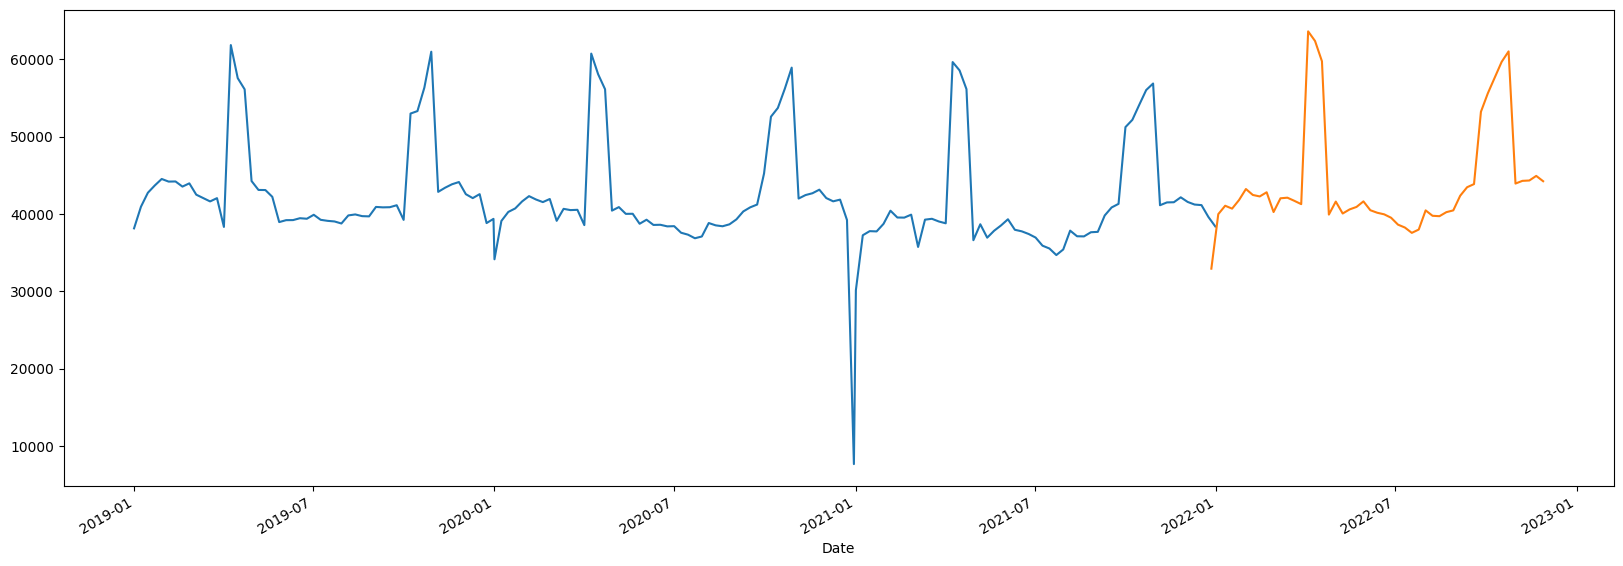

In [34]:
train.groupby(['Date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')
pred_plot.groupby(['Date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')



In [35]:
sample_sub.to_csv('submission.csv',index=False)

In [36]:
sample_sub

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,0.000000
1,ID_-0.510_29.290_2022_01,2.750516
2,ID_-0.510_29.290_2022_02,2.046319
3,ID_-0.510_29.290_2022_03,0.753982
4,ID_-0.510_29.290_2022_04,1.173824
...,...,...
24348,ID_-3.299_30.301_2022_44,31.518332
24349,ID_-3.299_30.301_2022_45,31.841824
24350,ID_-3.299_30.301_2022_46,31.566698
24351,ID_-3.299_30.301_2022_47,32.281517
